In [1]:
import cv2
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
import random
import numpy as np
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

predictor_path =  "/content/shape_predictor_68_face_landmarks.dat"

%matplotlib inline

--2021-07-02 16:36:11--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  48.8MB/s    in 1.3s    

2021-07-02 16:36:12 (48.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [2]:
faces_dir_path= "./faces"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
win_delaunay = "Delaunay Triangulation"
win_voronoi = "Voronoi Diagram"
delaunay_color = (0,0,255)
points_color = (0, 0, 255)
CV_AA = 16
max_frame = 600
df = 1/max_frame
fps = 20

In [3]:
def getPoints(img):
    points = []
    
    dets = detector(img, 1)
    for d in dets: 
        rect = patches.Rectangle((d.left(), d.top()), d.width(), d.height(), fill=False)
        
        parts = predictor(img, d).parts()
        points = [(point.x, point.y) for point in parts]
        points.extend([
            (0,0),
            (0, img.shape[0]-1),
            (img.shape[1]-1,0),
            (img.shape[1]-1, img.shape[0]-1),
            (0, img.shape[0]//2),
            (img.shape[1]//2, 0),
            (img.shape[1]-1, img.shape[0]//2),
            (img.shape[1]//2, img.shape[0]-1)
        ])
        
        return (points, rect)

def showPoints(img, points, rect):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.add_patch(rect)
    ax.scatter([point[0] for point in points], [point[1] for point in points], s=[20 for n in range(len(points))])        
    ax.imshow(img)
    
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True
 
def drawPoint(img, p, color ) :
    cv2.circle(img, p, 2, color, cv2.FILLED, CV_AA, 0 )

def drawDelaunay(img, triangles, delaunay_color) :
 
    size = img.shape
    r = (0, 0, size[1], size[0])
 
    for t in triangles :
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
         
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
            cv2.line(img, pt1, pt2, delaunay_color, 1, CV_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, CV_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, CV_AA, 0)

def drawVoronoi(img, subdiv) :
 
    (facets, centers) = subdiv.getVoronoiFacetList([])
 
    for i in range(0,len(facets)) :
        ifacet_arr = []
        for f in facets[i] :
            ifacet_arr.append(f)
         
        ifacet = np.array(ifacet_arr, np.int)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
 
        cv2.fillConvexPoly(img, ifacet, color, CV_AA, 0);
        ifacets = np.array([ifacet])
        cv2.polylines(img, ifacets, True, (0, 0, 0), 1, CV_AA, 0)
        cv2.circle(img, (centers[i][0], centers[i][1]), 3, (0, 0, 0), cv2.FILLED, CV_AA, 0)

def getDelaunayTriangles(img, points):
    size = img.shape
    rect = (0, 0, size[1], size[0])
    subdiv  = cv2.Subdiv2D(rect)

    for point in points:
        if rect_contains(rect, point):
            subdiv.insert(point)

    delaunayTri = []
    triangleList = subdiv.getTriangleList()
    
    for t in triangleList:
        pt = []
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))

        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)
            if len(ind) == 3:
                delaunayTri.append((ind[0], ind[1], ind[2]))

    return (triangleList, subdiv, delaunayTri)

def showTriangles(img, points, triangles, subdiv):
    drawDelaunay(img, triangles, delaunay_color)

    for p in points:
        drawPoint(img, p, points_color)
        
    img_voronoi = np.zeros(img.shape, dtype = img.dtype)
    
    drawVoronoi(img_voronoi, subdiv)

    # Show results
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(img)
    plt.subplot(2,2,2)
    plt.imshow(img_voronoi)


In [4]:
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst

# Warps and alpha blends triangular regions from img1 and img2 to img
def morphTriangle(img1, img2, img, t1, t2, t, alpha) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))


    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    tRect = []


    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
    warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask

(2724, 2268, 3)
(1881, 1397, 3)


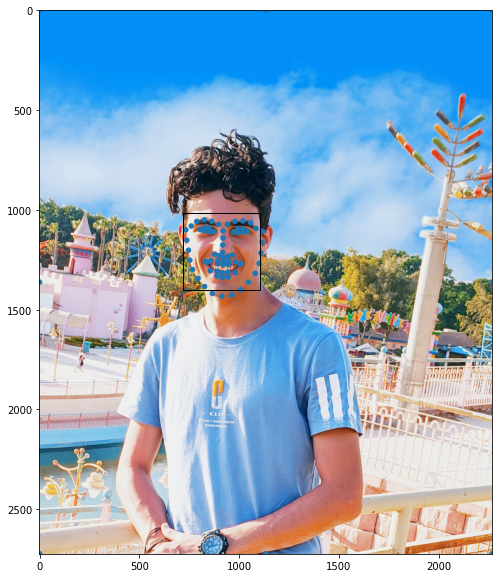

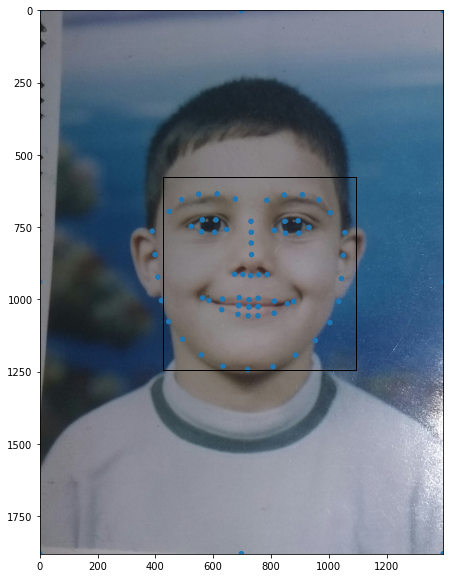

In [15]:
face_after_name = "/content/50.jpg"
face_before_name = "/content/13.jpg"
face_after_path = faces_dir_path+"/" + face_after_name
face_before_path = faces_dir_path+"/" + face_before_name

img1 = io.imread(face_after_name)
img2 = io.imread(face_before_name)

print(img1.shape)
print(img2.shape)

points1, rect1 = getPoints(img1)
points2, rect2 = getPoints(img2)

showPoints(img1, points1, rect1)
showPoints(img2, points2, rect2)

In [16]:
import time
start = time.time()
imgMorphs = []

for idx, alpha in enumerate([df*x for x in range(1,max_frame)], 1):
    points = []
    
    for i in range(0, len(points1)):
        x = ( 1 - alpha ) * points1[i][0] + alpha * points2[i][0]
        y = ( 1 - alpha ) * points1[i][1] + alpha * points2[i][1]
        points.append((x,y))
    
    _,_,delaunayTri = getDelaunayTriangles(img1, points)

    imgMorph = np.zeros(img1.shape, dtype = img1.dtype)

    for t in delaunayTri:
            t1 = [points1[t[0]], points1[t[1]], points1[t[2]]]
            t2 = [points2[t[0]], points2[t[1]], points2[t[2]]]
            t = [ points[t[0]], points[t[1]], points[t[2]] ]

            morphTriangle(img1, img2, imgMorph, t1, t2, t, alpha)
    
    imgMorphs.append(imgMorph)
    
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]") 

elapsed_time:583.6099286079407[sec]


In [17]:
# make morphing video

video_path= '/content/morphing_video_from_{}_to_{}_with_{}frame_{}fps.avi'.format(face_after_name, face_before_name,max_frame,fps)
height, width, layers = imgMorphs[0].shape

video = cv2.VideoWriter(video_path , -1, fps, (width, height))

for frame in imgMorphs:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video.write(frame_rgb)

cv2.destroyAllWindows()
video.release()

print("The output video is {}".format(video_path ))

The output video is ./morphing_video_from_/content/50.jpg_to_/content/13.jpg_with_600frame_20fps.avi


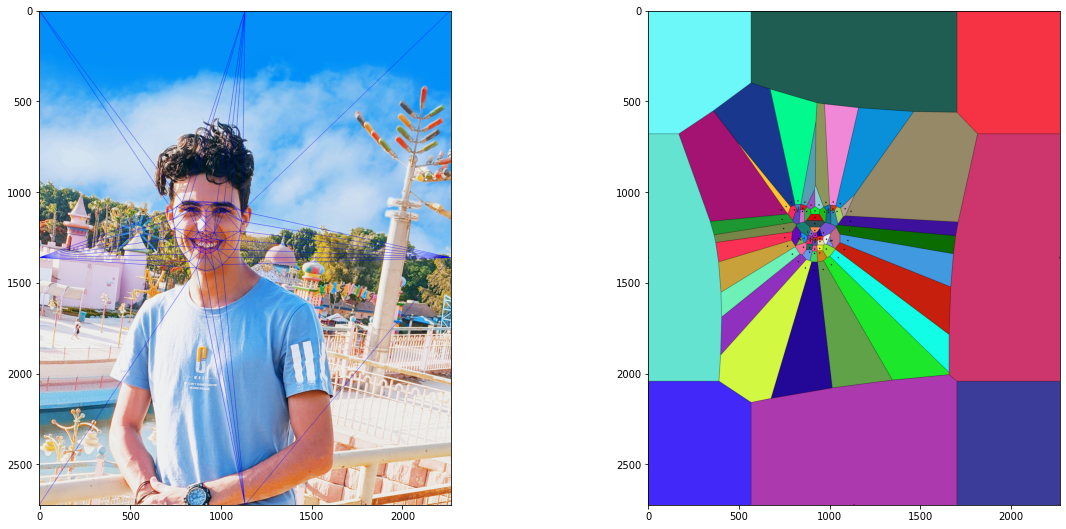

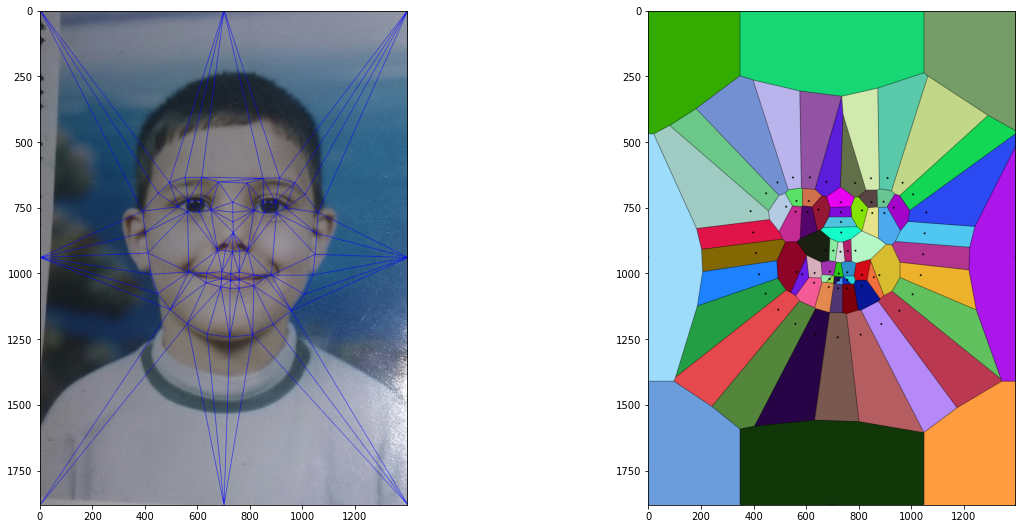

In [18]:
# show triangles
triangles, subdiv, _ = getDelaunayTriangles(img1, points1)
showTriangles(img1, points1, triangles, subdiv)

triangles2, subdiv2, _ = getDelaunayTriangles(img2, points2)
showTriangles(img2, points2, triangles2, subdiv2)

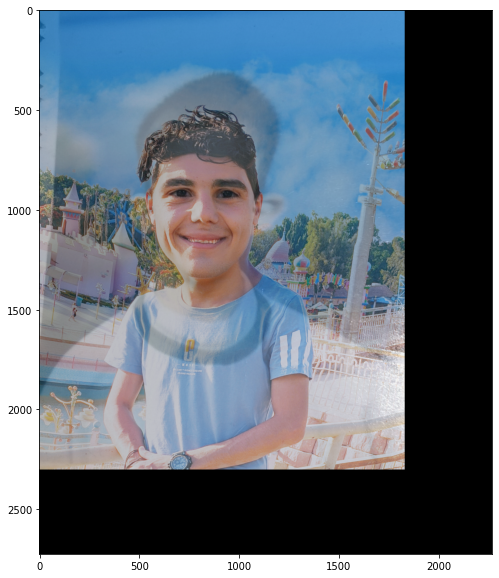

In [19]:
# show image of half & half
plt.figure(figsize=(10,10))
plt.imshow(imgMorphs[300])